# k- Nearest Neighbour for resource constrained devices

### Library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Importing MNIST data set

In [2]:
train_data = np.loadtxt('mnist_train.csv',delimiter=',')
test_data = np.loadtxt('mnist_test.csv',delimiter=',')



### Seperating features and labels in training and test data

In [3]:
x_train = train_data[:,1:len(train_data[0])]
t_train = train_data[:,0]

x_test = test_data[:,1:len(train_data[0])]
t_test = test_data[:,0]

In [4]:
# x_train, t_train, x_test, t_test = mnist.load()
print(x_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Function to plot MNIST image data

In [5]:
def plotimage(img):
    img = img.reshape(28,28)
    fig = plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='gray')
    plt.show()

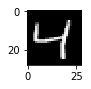

In [6]:
plotimage(x_train[2])

### k-NN on original MNIST dataset

In [20]:
def knnoriginal(train_data,test_data,k):
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    X = train_data[:,1:]
    y = train_data[:,0]
    knnmodel.fit(X,y)
    t_pred = knnmodel.predict(test_data[:,1:])
    acc = accuracy_score(test_data[:,0],t_pred)
    print(acc)
    
# knnoriginal(train_data,test_data,1)

Gave an accuracy result of ~94%

### tSNE embedding

tSNE embeddings were computed once and store in permanent files, to avoid recomputation and waste of time. The code for same isn't included in this notebook.

Sampling batch of 5 for each class from tSNE embedding of training data points with 2 components retained

In [9]:
batchof5 = []
for i in range(10):
    i_rows = tsne_train[tsne_train[:,2] == i]
    temp = i_rows[np.random.choice(i_rows.shape[0], 5, replace=False), :]
    batchof5.extend(temp)

batchof5 = np.array(batchof5)


Applying k-NN using batch of 5 data points sampled from each class

In [10]:
knnmodel = KNeighborsClassifier(n_neighbors=5,weights='distance')
X = batchof5[:,:2]

y = batchof5[:,2]
knnmodel.fit(X,y)
t_pred = knnmodel.predict(tsne_test[:,:2])
acc = accuracy_score(t_test,t_pred)
print(acc)

0.0745


Using tSNE features (2 components):

Random sampling of size 5 from each class, as training data, gave bad accuracy.
Below 15% for 1<= k < 50.

### Approach 1 : 

### Function to compute class centroid

In [7]:
def classcentroid(data,labels):
    colstack = np.column_stack((labels,data))
    centroid = []
    for i in range(10):
        temp = colstack[colstack[:,0]==i]
        mean = temp.mean(0)
        centroid.append(mean)
    centroid = np.array(centroid)
    return centroid[:,1:]

### Using centroid of each class as training data

10 training data points, similar to prototype based classification.

In [12]:
centroid = classcentroid(train_data[:,1:],train_data[:,0])
knnmodel = KNeighborsClassifier(n_neighbors=1)
X = centroid[:,:]
print(X.shape)
y = [x for x in range(10)]
knnmodel.fit(X,y)
t_pred = knnmodel.predict(test_data[:,1:])
acc = accuracy_score(test_data[:,0],t_pred)
print(acc)

(10, 784)
0.8203


Using all the features 1-NN gave accuracy of 82% if centroid of each class are used as training data (prototype based classification) i.e. training contains 10 images.
Around 3KB storage for 10 images representing centroids of 10 classes.

We even tried the above approach with tSNE embedding with 2 components only

In [11]:
centroid = []
for i in range(10):
    i_rows = tsne_train[tsne_train[:,2] == i]
    ctd = i_rows.mean(0)
    centroid.append(ctd)

centroid = np.array(centroid)
print(centroid)

[[ 15.76596116  40.40749467   0.        ]
 [-38.75760934 -18.43028952   1.        ]
 [-33.21055203  12.17535129   2.        ]
 [-13.99258063  29.08090695   3.        ]
 [ 27.9640125  -17.64217713   4.        ]
 [ 13.08005988  11.27953151   5.        ]
 [ 39.53528224  13.64157858   6.        ]
 [ -6.71965901 -37.35046684   7.        ]
 [ -8.43246001  -0.71406104   8.        ]
 [ 12.09071812 -27.27868829   9.        ]]


In [12]:
knnmodel = KNeighborsClassifier(n_neighbors=1,weights='distance')
X = centroid[:,:2]

y = centroid[:,2]
knnmodel.fit(X,y)
t_pred = knnmodel.predict(tsne_test[:,:2])
acc = accuracy_score(t_test,t_pred)
print(acc)

0.1322


1-NN: Very bad accuracy (13%) even with centroids (10 centroids for 10 classes i.e. why 1-NN) on tSNE features (2 components only).

### Trying PCA with n components retained

#### Function to compute PCA embeddings for given n components

In [15]:
from sklearn.decomposition import PCA
def computePCA(X,n):
    pcamodel = PCA(n_components=n)
    return pcamodel.fit_transform(X)
    

In [17]:
def centroidPCA(train_data,test_data,n):
    train_data[:,1:] = standardize(train_data[:,1:])
    test_data[:,1:] = standardize(test_data[:,1:])
    pca_train = computePCA(train_data[:,1:],n)
    pca_test = computePCA(test_data[:,1:],n)
    centroid = classcentroid(pca_train,train_data[:,0])
    return centroid,pca_test

def KnnPCAcentroid(train_data,test_data,n,k):
    centroid,pca_test = centroidPCA(train_data,test_data,n)
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    X = centroid
    y = [i for i in range(10)]
    knnmodel.fit(X,y)
    t_pred = knnmodel.predict(pca_test)
    acc = accuracy_score(t_test,t_pred)
    print(acc)
    

#### Function to model k-NN classifier on PCA embeddings i.e. features = n, no. of samples = total samples in MNIST data set

In [14]:
def KnnPCA(train_data,test_data,n,k):
    train_data[:,1:] = standardize(train_data[:,1:])
    test_data[:,1:] = standardize(test_data[:,1:])
    pca_train = computePCA(train_data[:,1:],n)
    pca_test = computePCA(test_data[:,1:],n)
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    X = pca_train
    y = train_data[:,0]
    knnmodel.fit(X,y)
    t_pred = knnmodel.predict(pca_test)
    
    acc = accuracy_score(t_test,t_pred)
    print("With n=%d components and k=%d neighbors we get accuracy score = %f"%(n,k,acc))
    return acc
    

We tried a combination of n and k to test k-NN model on training data with dimensionality reduced using PCA technique. n = no. of components retained, k = no. of neighbors

(Data is standardized before applying PCA)

With n=2 components and k=1 neighbors we get accuracy score = 0.292000
With n=4 components and k=1 neighbors we get accuracy score = 0.414000
With n=7 components and k=1 neighbors we get accuracy score = 0.644600
With n=14 components and k=1 neighbors we get accuracy score = 0.501100
With n=16 components and k=1 neighbors we get accuracy score = 0.539400
With n=2 components and k=3 neighbors we get accuracy score = 0.315700
With n=4 components and k=3 neighbors we get accuracy score = 0.440000
With n=7 components and k=3 neighbors we get accuracy score = 0.680700
With n=14 components and k=3 neighbors we get accuracy score = 0.531700
With n=16 components and k=3 neighbors we get accuracy score = 0.476900
With n=2 components and k=5 neighbors we get accuracy score = 0.329200
With n=4 components and k=5 neighbors we get accuracy score = 0.450100
With n=7 components and k=5 neighbors we get accuracy score = 0.695100
With n=14 components and k=5 neighbors we get accuracy score = 0.506700
W

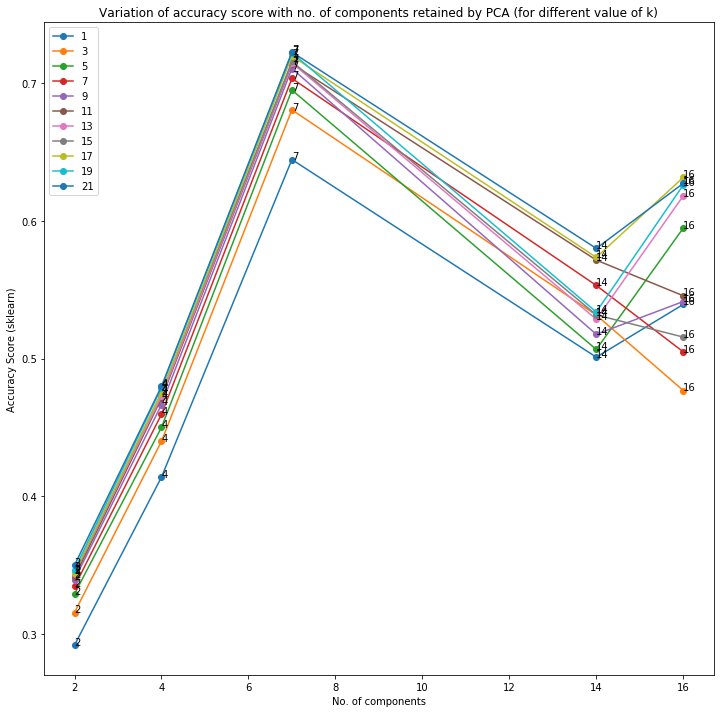

In [18]:
components = [2,4,7,14,16]
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
neighacc = []
for n in neighbors:
    acc = []
    for c in components:
        acc.append(KnnPCA(train_data,test_data,c,n))
    neighacc.append(acc)
neighacc = np.array(neighacc)
print(neighacc.shape)
fig = plt.figure(figsize=(12,12))
for ac in neighacc:
    plt.plot(components,ac,marker='o')
    for i,txt in enumerate(components):
        plt.annotate(txt,(components[i],ac[i]))

plt.xlabel('No. of components')
plt.ylabel('Accuracy Score (sklearn)')
plt.legend(neighbors,loc='upper left')
plt.title('Variation of accuracy score with no. of components retained by PCA (for different value of k)')
plt.show()

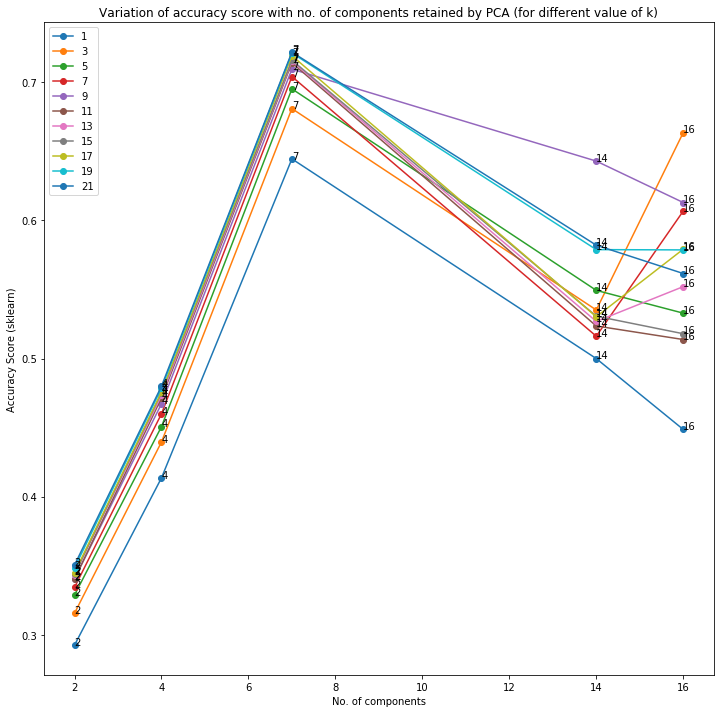

In [111]:
fig = plt.figure(figsize=(12,12))
for ac in neighacc:
    plt.plot(components,ac,marker='o')
    for i,txt in enumerate(components):
        plt.annotate(txt,(components[i],ac[i]))

plt.xlabel('No. of components')
plt.ylabel('Accuracy Score (sklearn)')
plt.legend(neighbors,loc='upper left')
plt.title('Variation of accuracy score with no. of components retained by PCA (for different value of k)')
plt.show()

### Following are few tests carried out with varying no. of components in PCA and k in k-NN model.

In [232]:
KnnPCA(train_data,test_data,2,1)

0.292


In [233]:
KnnPCAcentroid(train_data,test_data,2,1)

0.3486


In [234]:
KnnPCA(train_data,test_data,2,5)

0.3294


In [235]:
KnnPCA(train_data,test_data,2,1001)

0.3668


In [236]:
KnnPCA(train_data,test_data,2,10001)

0.3317


In [237]:
KnnPCA(train_data,test_data,4,1)

0.4139


In [238]:
KnnPCAcentroid(train_data,test_data,4,1)

0.5245


In [239]:
KnnPCA(train_data,test_data,4,5)

0.4505


In [240]:
KnnPCA(train_data,test_data,4,1001)

0.5592


In [241]:
KnnPCA(train_data,test_data,4,10001)

0.4979


In [242]:
KnnPCA(train_data,test_data,7,1)

0.6439


In [243]:
KnnPCAcentroid(train_data,test_data,7,1)

0.6205


In [244]:
KnnPCA(train_data,test_data,7,3)

0.6807


In [245]:
KnnPCA(train_data,test_data,7,5)

0.6948


In [246]:
KnnPCA(train_data,test_data,7,7)

0.703


In [247]:
KnnPCA(train_data,test_data,7,9)

0.7096


In [248]:
KnnPCA(train_data,test_data,7,28)

0.726


In [249]:
KnnPCAcentroid(train_data,test_data,14,1)

0.5686


In [17]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    return StandardScaler().fit_transform(data)


### Approach 2

### Landmark Based Similarity features

In [20]:
from scipy.spatial import distance
from sklearn.model_selection import cross_val_score
def rbfkernel(xn,xm,gamma=0.1):
    l2NormSquared = (distance.euclidean(xn,xm))**2
    RBFexponent = -1*gamma*l2NormSquared
    return np.exp(RBFexponent)


def datatolandmarkfeaturesrandom(data,randomfeatures):
    print(randomfeatures.shape)
    d2lfeatures = []
    X= data[:,1:]
    for x in X:
        temp = []
        for rf in randomfeatures:
            temp.append(rbfkernel(x,rf))
        d2lfeatures.append(temp)
    d2lfeatures = np.array(d2lfeatures)
    print(d2lfeatures.shape)
    return d2lfeatures
    
def datatolandmarkfeaturescentroid(data,centroid,g):
    X = data[:,1:]
    d2lfeatures = []
    for x in X:
        temp = []
        for c in centroid:
            temp.append(rbfkernel(x,c,g))
        d2lfeatures.append(temp)
    d2lfeatures = np.array(d2lfeatures)
    return d2lfeatures

def knnrandomlandmark(traindata,testdata,L,k):
    idx = np.random.randint(len(traindata), size=L)
    randomfeatures = traindata[idx,1:]
    randomXtrain = datatolandmarkfeaturesrandom(traindata,randomfeatures)
    randomXtest = datatolandmarkfeaturesrandom(testdata,randomfeatures)
    y = traindata[:,0]
    y_test = testdata[:,0]
    myList = list(range(1,100))

    neighbors = filter(lambda x: x % 2 != 0, myList)
    cv_scores = []
    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n)
        scores = cross_val_score(knn, randomXtrain, y, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print ("The optimal number of neighbors is %d" % optimal_k)

    # plot misclassification error vs k
    plt.plot(neighbors, MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()


def countcorrectpred(y_test,t_pred):
    count = 0
    for i,j in zip(y_test,t_pred):
        if i == j:
            count += 1
    return count
    
def knncentroidlandmark(traindata,testdata,k):
    centroid = classcentroid(data[:,1:],data[:,0])
    centroidXtrain = datatolandmarkfeaturescentroid(traindata,centroid)
    centroidXtest = datatolandmarkfeaturescentroid(testdata,centroid)
    y = traindata[:,0]
    y_test = testdata[:,0]
    
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    knnmodel.fit(centroidXtrain,y)
    t_pred = knnmodel.predict(centroidXtest)
    print(t_pred.shape)
    acc = accuracy_score(y_test,t_pred,normalize=False)
    correctcount = countcorrectpred(y_test,t_pred)
    print(acc)
    
# knnrandomlandmark(train_data,test_data,100,3)

We achieved the highest accuracy of ~76% with L=200 and k=31. The size of training data required at test time required was around 45MB.

(10, 784)
For gamma = 0.000050, correct pred = 8089
For gamma = 0.000080, correct pred = 8089
For gamma = 0.000100, correct pred = 8089
For gamma = 0.000150, correct pred = 8089
For gamma = 0.000200, correct pred = 8089
For gamma = 0.000250, correct pred = 8089
For gamma = 0.000330, correct pred = 8089
For gamma = 0.000400, correct pred = 8089
For gamma = 0.000500, correct pred = 8089
For gamma = 0.001000, correct pred = 8089
For gamma = 0.010000, correct pred = 8089
For gamma = 0.100000, correct pred = 8055


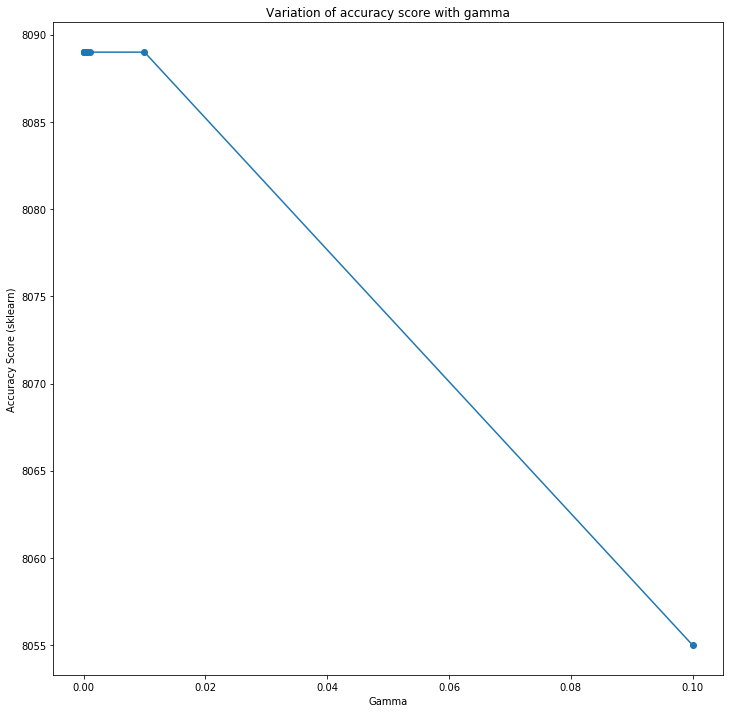

In [30]:
centroid = classcentroid(train_data[:,1:],train_data[:,0])
print(centroid.shape)
x = [0.00005,0.00008,0.0001,0.00015,0.0002,0.00025,0.00033,0.0004,0.0005,0.001,0.01,0.1]
acc = []
for g in x:
    centroidXtrain = datatolandmarkfeaturescentroid(train_data,centroid,g)
    centroidXtest = datatolandmarkfeaturescentroid(test_data,centroid,g)
    output = similaritymax1(centroidXtest)
#     acc = []
    acc.append(accuracy_score(test_data[:,0],output,normalize=False))
    count = countcorrectpred(test_data[:,0],output)
    print('For gamma = %f, correct pred = %d'%(g,count))


fig = plt.figure(figsize=(12,12))
plt.plot(x,acc,marker='o')
plt.xlabel('Gamma')
plt.ylabel('Accuracy Score (sklearn)')
plt.title('Variation of accuracy score with gamma')
plt.show()

For centroid as landmark we achieved highest accuracy of ~81%
Size of training required for k-NN at test time was reduced to ~2.5 MB

### Function which returns index of maximum value of similarity in a list of similarity values ( similarity as RBF Kernel value)

In [29]:
def similaritymax1(data):
    output = []
    for x in data:
        x = list(x)
        output.append(x.index(max(x)))
    return output

output = similaritymax1(centroidXtest)
countcorrectpred(test_data[:,0],output)


8089

For above approach, with a goal to reduce the training data size required for k-NN model at test time we applied PCA on the original training data and then used the reduced features to compute similarity value (RBF kernel). It is an extension of above approach.

In [121]:
traindata = np.copy(train_data)
testdata = np.copy(test_data)
traindata[:,1:] = standardize(train_data[:,1:]) 
testdata[:,1:] = standardize(test_data[:,1:]) 

component = [4,7,20,50,100,150,200,300]
for c in component:
    pcatrain = computePCA(train_data[:,1:],c)
    pcatest = computePCA(test_data[:,1:],c)

    centroid = classcentroid(pcatrain,train_data[:,0])
    x = [0.000000001,0.00003,0.000035,0.00008,0.0001,0.00015,0.0002,0.00025, 0.00033,0.0004,0.0005,0.01]
    pcatrain = np.column_stack((train_data[:,0],pcatrain))
    pcatest = np.column_stack((test_data[:,0],pcatest))

    for g in x:
        centroidXtrain = datatolandmarkfeaturescentroid(pcatrain,centroid,g)
        centroidXtest = datatolandmarkfeaturescentroid(pcatest,centroid,g)
        output = similaritymax1(centroidXtest)
        count = countcorrectpred(test_data[:,0],output)
        print('For c=%d, gamma = %f, correct pred = %d'%(c,g,count))

For c=4, gamma = 0.000000, correct pred = 5246
For c=4, gamma = 0.000030, correct pred = 5246
For c=4, gamma = 0.000035, correct pred = 5246
For c=4, gamma = 0.000080, correct pred = 5246
For c=4, gamma = 0.000100, correct pred = 5246
For c=4, gamma = 0.000150, correct pred = 5246
For c=4, gamma = 0.000200, correct pred = 5246
For c=4, gamma = 0.000250, correct pred = 5246
For c=4, gamma = 0.000330, correct pred = 5246
For c=4, gamma = 0.000400, correct pred = 5246
For c=4, gamma = 0.000500, correct pred = 5246
For c=4, gamma = 0.010000, correct pred = 5246
For c=7, gamma = 0.000000, correct pred = 6206
For c=7, gamma = 0.000030, correct pred = 6206
For c=7, gamma = 0.000035, correct pred = 6206
For c=7, gamma = 0.000080, correct pred = 6206
For c=7, gamma = 0.000100, correct pred = 6206
For c=7, gamma = 0.000150, correct pred = 6206
For c=7, gamma = 0.000200, correct pred = 6206
For c=7, gamma = 0.000250, correct pred = 6206
For c=7, gamma = 0.000330, correct pred = 6206
For c=7, gamm

As the results suggest we got maximum accuracy of ~62% with 4 components retained using PCA. The accuracy was reduced as compared to the original approach but data size required at test time was reduced to ~ 1 MB.

### Approach 3

### Centroid as landmark points

For k=1 we get accuracy score=0.756000
For k=3 we get accuracy score=0.790600
For k=5 we get accuracy score=0.808100
For k=7 we get accuracy score=0.809400
For k=9 we get accuracy score=0.810600
For k=11 we get accuracy score=0.810300
For k=13 we get accuracy score=0.810800
For k=15 we get accuracy score=0.807500
For k=17 we get accuracy score=0.808200
For k=19 we get accuracy score=0.807000
For k=21 we get accuracy score=0.806700
For k=23 we get accuracy score=0.806200
For k=25 we get accuracy score=0.804700
For k=27 we get accuracy score=0.805300
For k=29 we get accuracy score=0.804700
For k=31 we get accuracy score=0.805700
For k=33 we get accuracy score=0.804500
For k=35 we get accuracy score=0.804500
For k=37 we get accuracy score=0.804200
For k=39 we get accuracy score=0.804200
For k=41 we get accuracy score=0.804000
For k=43 we get accuracy score=0.804100
For k=45 we get accuracy score=0.803500
For k=47 we get accuracy score=0.803800
For k=49 we get accuracy score=0.803600
For k

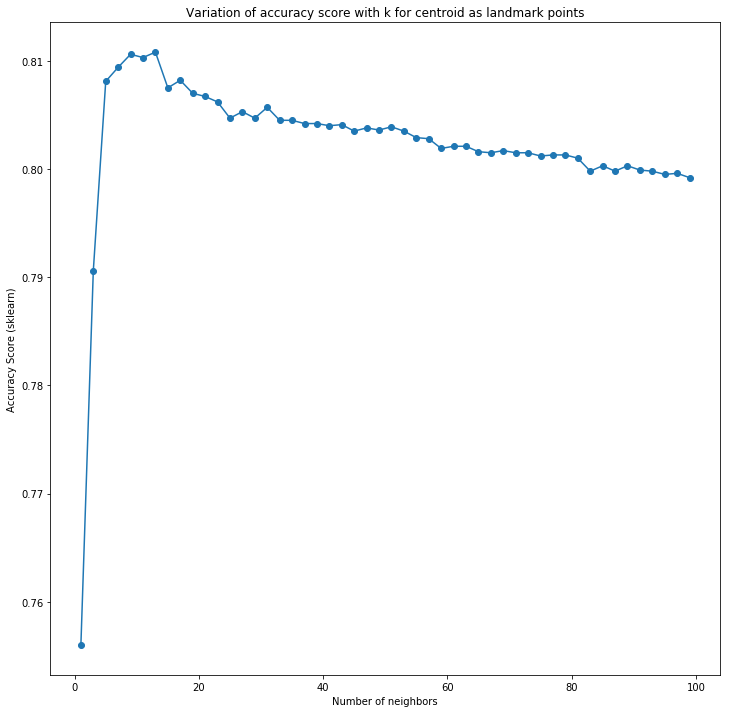

In [31]:
def datatolandmarkfeaturescentroid1(data,centroid):
    X = data[:,1:]
    d2lfeatures = []
    for x in X:
        temp = []
        for c in centroid:
            temp.append(rbfkernel(x,c))
        d2lfeatures.append(temp)
    d2lfeatures = np.array(d2lfeatures)
    return d2lfeatures

def knncentroidlandmark1(traindata,testdata):
    neighbors = [x for x in range(1,100,2)]
    traindata[:,1:] = standardize(traindata[:,1:]) 
    testdata[:,1:] = standardize(testdata[:,1:]) 
    centroid = classcentroid(traindata[:,1:],traindata[:,0])
    centroidXtrain = datatolandmarkfeaturescentroid1(traindata,centroid)
    centroidXtest = datatolandmarkfeaturescentroid1(testdata,centroid)
    y = traindata[:,0]
    y_test = testdata[:,0]
    acclist = []
    for n in neighbors:
        knnmodel = KNeighborsClassifier(n_neighbors=n)
        knnmodel.fit(centroidXtrain,y)
        t_pred = knnmodel.predict(centroidXtest)
        acc = accuracy_score(y_test,t_pred)
        acclist.append(acc)
        print('For k=%d we get accuracy score=%f'%(n,acc))
    
    fig = plt.figure(figsize=(12,12))
    plt.plot(neighbors,acclist,marker='o')
    plt.xlabel('Number of neighbors')
    plt.ylabel('Accuracy Score (sklearn)')
    plt.title('Variation of accuracy score with k for centroid as landmark points')
    plt.show()
    
knncentroidlandmark1(train_data,test_data)
